In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy


In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
import fastai; fastai.__version__

'1.0.54'

In [5]:
np.random.seed(42)

In [6]:

def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [7]:
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [8]:

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False, sym=False):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.sa = SimpleSelfAttention(nf,ks=1)
        
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))

In [9]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [10]:
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [11]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)


class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):#, n_out:int):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
        c = self.conv.weight.view(self.n_in,self.n_in)
        c = (c + c.t())/2
        self.conv.weight = c.view(self.n_in,self.n_in,1)

        size = x.size()  
        x = x.view(*size[:2],-1)   # (C,N)
        
        # changed the order of mutiplication to avoid O(N^2) complexity
        # (x*xT)*(W*x) instead of (x*(xT*(W*x)))
        
        convx = self.conv(x)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())   # (C,N) * (N,C) = (C,C)   => O(NC^2)
        
        o = torch.bmm(xxT, convx)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
          
        o = self.gamma * o + x
        
          
        return o.view(*size).contiguous()        

In [12]:
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [13]:
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False):
        super().__init__()
        
        
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
                
        ]
        
        self.sa = SimpleSelfAttention(nf,ks=1) if sa else noop
        
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): 
        
        
        return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))

In [14]:
class XResNet_sa(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, sa = True if i in[len(layers)-4] else False)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, sa = False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [n_blocks -1] else False)
              for i in range(n_blocks)])

In [15]:
def xresnet50_sa (**kwargs): return XResNet_sa.create(4, [3, 4,  6, 3], **kwargs)
def xresnet152_sa(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [16]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [17]:
src.add_test_folder('/home/ubuntu/snakes_breed/round1')

LabelLists;

Train: LabelList (65934 items)
x: ImageList
Image (3, 375, 500),Image (3, 500, 375),Image (3, 352, 500),Image (3, 800, 440),Image (3, 500, 281)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 375, 500),Image (3, 500, 371),Image (3, 375, 500),Image (3, 500, 375),Image (3, 375, 500)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: LabelList (17687 items)
x: ImageList
Image (3, 500, 375),Image (3, 333, 500),Image (3, 600, 800),Image (3, 1125, 2000),Image (3, 2000, 1500)
y: EmptyLabelList
,,,,
Path: train

In [18]:
epochs = 5
lr = 1e-3
bs = 64
mixup = 0.2
image_size = 360

In [19]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [20]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).presize(image_size, scale=(0.35,1)).normalize())

In [21]:
data

ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: LabelList (17687 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: EmptyLabelList
,,,,
Path: train

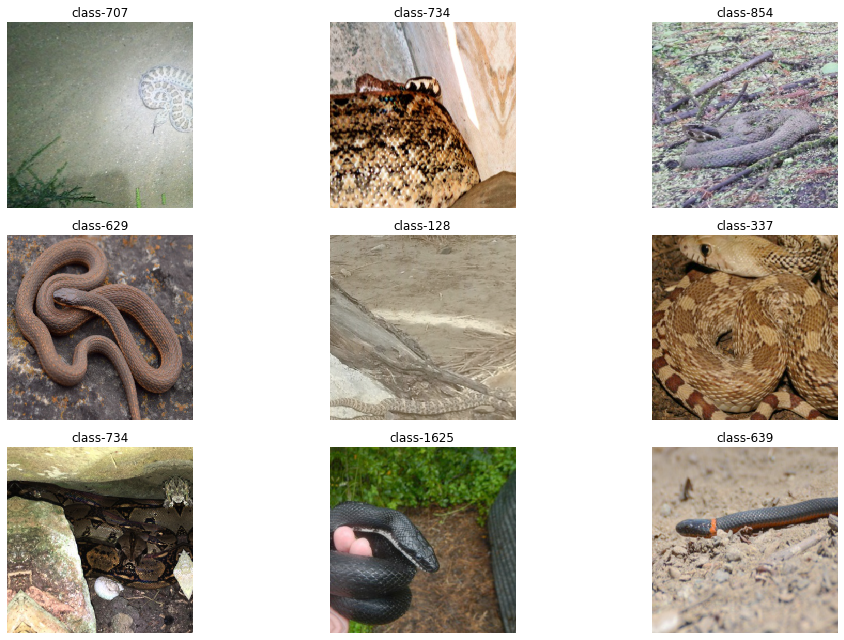

In [22]:
data.show_batch(3,figsize=(15,9))

In [23]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)


In [24]:
m = xresnet50_sa(c_out=45)


In [25]:
learn = (Learner(data, m, wd=1e-2, opt_func=opt_func,
             metrics=[accuracy,FBeta(beta=1,average='macro')],
             bn_wd=False, true_wd=True,
             loss_func = LabelSmoothingCrossEntropy())
            )

In [26]:
if mixup: learn = learn.mixup(alpha=mixup)


In [27]:
learn = learn.to_fp16(dynamic=True)


In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


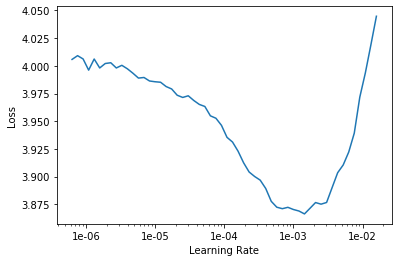

In [29]:
learn.recorder.plot(suggesion=True)

In [30]:
learn.fit_one_cycle(epochs, lr, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,3.430488,3.364646,0.167749,0.033917,09:44
1,3.060642,2.940326,0.277498,0.128871,09:43
2,2.780116,2.607843,0.368986,0.212283,09:42
3,2.548417,2.267407,0.476006,0.339044,09:43
4,2.456124,2.165653,0.511011,0.382632,09:44


In [31]:
learn.save('xresnet-360-round-1')

In [ ]:
epochs=20

In [ ]:
learn.fit_one_cycle(epochs, lr, div_factor=10, pct_start=0.3)